In [71]:
from matplotlib import pyplot as plt
from math import sqrt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

# Project 2 Task 5

In [2]:
data = pd.read_excel("18EA1-5 database cleaned HO only-version2.xlsx")

### Data Analysis

In [3]:
data.head(5)

,Cow,Farm,System,Parity,ParityCategory,BCS,DIM,DIC,Pregnant,FatPEBV,...,"10,12/preformed",20:2n6/preformed,22/preformed,20:3n6/preformed,20:4n6/preformed,20:5n3/preformed,MFD,(C13 - C11)/OBC,(C14 - C12)/DN,Trans as % of preformed
0,43,1,CM,5,3plus,3.250,200.0,0,N,-0.200,...,0.00000,0.000726,0.000663,0.004169,0.003576,0.000746,No,0.017162,0.305421,0.075902
1,51,1,CM,5,3plus,2.750,72.0,0,U,0.070,...,0.00162,0.000000,0.000624,0.001575,0.002038,0.000000,Yes,0.022726,0.281875,0.197800
2,405,1,CM,5,3plus,NaN,212.0,0,N,NaN,...,0.00000,0.001104,0.001000,0.003100,0.004451,0.000705,No,0.010826,0.240153,0.084820
3,408,1,CM,4,3plus,2.750,211.0,0,U,-0.070,...,0.00000,0.001005,0.000442,0.002461,0.004562,0.000727,Yes,0.013623,0.296892,0.105783
4,423,1,CM,5,3plus,2.875,228.0,0,N,-0.215,...,0.00000,0.000849,0.000583,0.003857,0.003656,0.000480,Yes,0.011611,0.297311,0.098821


#### Null values in Dataset

In [4]:
null_summary = data.isnull().sum().sort_values(ascending=False)

In [5]:
for i, j in zip(null_summary.index, null_summary.values):
    print("Column: %s" % i)
    print("\tNull Count: %d\n" % j)

Column: C20:2n6
	Null Count: 959

Column: BCS
	Null Count: 452

Column: C20:1c11
	Null Count: 273

Column: C18:1t4
	Null Count: 177

Column: i130/OBC
	Null Count: 171

Column: iC13:0
	Null Count: 171

Column: C18:1t5
	Null Count: 170

Column: FatPEBV
	Null Count: 118

Column: C18:3c9c12c15
	Null Count: 116

Column: C18:3c6c9c12
	Null Count: 114

Column: aC17:0
	Null Count: 108

Column: a17/OBC
	Null Count: 108

Column: C22:0
	Null Count: 56

Column: C20:4n6
	Null Count: 32

Column: C20:3n6
	Null Count: 25

Column: C18:1t15
	Null Count: 22

Column: 17/OBC
	Null Count: 16

Column: C17:0
	Null Count: 16

Column: iC15:0
	Null Count: 14

Column: i15/OBC
	Null Count: 14

Column: Fat%
	Null Count: 13

Column: C18:1t12
	Null Count: 11

Column: C20:0
	Null Count: 9

Column: iC17:0
	Null Count: 8

Column: C18:2c9c12
	Null Count: 7

Column: iC14:0
	Null Count: 2

Column: i14/OBC
	Null Count: 2

Column: C11/OBC
	Null Count: 1

Column: C12:0
	Null Count: 1

Column: a130/OBC
	Null Count: 1

Column: 

C20:2n6 and BCS have too many null values. These are features that seem like they would be important in determining our target values. Imputing for these instances would not be smart, as it could have negative effects on our model. We will choose to remove these two features instead, in order to preserve more data. 

### Data Preprocessing

In [6]:
# get only numerical features
filtered_data = data.select_dtypes(include="float")

In [7]:
numerical_features = filtered_data.columns
categorical_features = data.columns.difference(filtered_data.columns)
targets = ["AvgMilk", "Fat%", "FatY", "Pro%", "ProY"]
null_columns = list(null_summary.index[:12])

In [25]:
# drop target and features with too many nulls, then drop rows with null values
X = filtered_data.drop(targets + null_columns, axis=1).dropna()

# subset y with rows of X, and drop target rows with null values
y = data.loc[X.index, targets].dropna()

# subset X for only available rows of y
X = X.loc[y.index, :]

# normalize feature vectors
X = X.apply(lambda x: (x - x.mean()) / x.std())

d = X.shape[1]

### Principal Component Analysis

In [9]:
pca = PCA(n_components=10)
pca.fit(X, y["AvgMilk"])
new_X = pca.transform(X)
print(pca.explained_variance_ratio_)  
print(pca.singular_values_) 

[0.2657318  0.12593477 0.09848896 0.07562923 0.06022837 0.05129419
 0.03768322 0.0282215  0.02362532 0.02232748]
[209.56501168 144.26794082 127.58240635 111.80001615  99.76944987
  92.0727457   78.91707896  68.29470764  62.48644906  60.74589088]


In [45]:
lasso_pca_target_scores = {}
lasso_pca_target_rmse = {}
lasso_pca_target_adjr2 = {}
lasso_target_scores = {}
lasso_target_rmse = {}
lasso_target_adjr2 = {}
rf_pca_target_scores = {}
rf_pca_target_rmse = {}
rf_pca_target_adjr2 = {}
rf_target_scores = {}
rf_target_rmse = {}
rf_target_adjr2 = {}

lasso_pca_preds = {}
lasso_preds = {}
rf_pca_preds = {}
rf_preds= {}

target_pca_splits = {}
target_splits = {}

In [46]:
for target in targets:
    target_splits[target] = train_test_split(X, y[target],test_size=.3)
    target_pca_splits[target] = train_test_split(new_X, y[target],test_size=.3)

### Lasso with PCA

In [48]:
# lasso with PCA
for target in targets:
    X_train, X_test, y_train, y_test = target_pca_splits[target]

    lasso = Lasso(alpha=0)
    lasso.fit(X_train, y_train)
    lasso_pca_target_scores[target] = lasso.score(X_test, y_test)
    lasso_pca_preds[target] = lasso.predict(X_test)
    lasso_pca_target_adjr2[target] = (1 - (1 - lasso_pca_target_scores[target]) *
                          ((len(X_train) - 1) / (len(X_train) - d - 1)))
    lasso_pca_target_rmse[target] = sqrt(mean_squared_error(y_test, lasso_pca_preds[target]))

### Lasso without PCA

In [49]:
for target in targets:
    X_train, X_test, y_train, y_test = target_splits[target]

    lasso = Lasso(alpha=0)
    lasso.fit(X_train, y_train)
    lasso_target_scores[target] = lasso.score(X_test, y_test)
    lasso_preds[target] = lasso.predict(X_test)
    lasso_target_adjr2[target] = (1 - (1 - lasso_target_scores[target]) *
                          ((len(X_train) - 1) / (len(X_train) - d - 1)))
    lasso_target_rmse[target] = sqrt(mean_squared_error(y_test, lasso_preds[target]))

### Random Forest with PCA

In [50]:
for target in targets:
    X_train, X_test, y_train, y_test = target_pca_splits[target]

    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_train, y_train)
    rf_pca_target_scores[target] = rf.score(X_test, y_test)
    rf_pca_preds[target] = rf.predict(X_test)
    rf_pca_target_adjr2[target] = (1 - (1 - rf_pca_target_scores[target]) *
                          ((len(X_train) - 1) / (len(X_train) - d - 1)))
    rf_pca_target_rmse[target] = sqrt(mean_squared_error(y_test, rf_pca_preds[target]))

### Random Forest without PCA

In [51]:
for target in targets:
    X_train, X_test, y_train, y_test = target_splits[target]
    
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_train, y_train)
    rf_target_scores[target] = rf.score(X_test, y_test)
    rf_preds[target] = rf.predict(X_test)
    rf_target_adjr2[target] = (1 - (1 - rf_target_scores[target]) *
                          ((len(X_train) - 1) / (len(X_train) - d - 1)))
    rf_target_rmse[target] = sqrt(mean_squared_error(y_test, rf_preds[target]))

In [63]:
print("Lasso with PCA")
print("R^2")
print(pd.Series(lasso_pca_target_scores), end="\n\n")
print("Adjusted R^2")
print(pd.Series(lasso_pca_target_adjr2), end="\n\n")
print("RMSE")
print(pd.Series(lasso_pca_target_rmse), end="\n\n")

print("------------------------------", end="\n\n")

print("Lasso without PCA")
print("R^2")
print(pd.Series(lasso_target_scores), end="\n\n")
print("Adjusted R^2")
print(pd.Series(lasso_target_adjr2), end="\n\n")
print("RMSE")
print(pd.Series(lasso_target_rmse), end="\n\n")

print("------------------------------", end="\n\n")

print("Random Forest with PCA")
print("R^2")
print(pd.Series(rf_pca_target_scores), end="\n\n")
print("Adjusted R^2")
print(pd.Series(rf_pca_target_adjr2), end="\n\n")
print("RMSE")
print(pd.Series(rf_pca_target_rmse), end="\n\n")

print("------------------------------", end="\n\n")

print("Random Forest without PCA")
print("R^2")
print(pd.Series(rf_target_scores), end="\n\n")
print("Adjusted R^2")
print(pd.Series(rf_target_adjr2), end="\n\n")
print("RMSE")
print(pd.Series(rf_target_rmse))

Lasso with PCA
R^2
AvgMilk    0.744273
Fat%       0.413172
FatY       0.959183
Pro%       0.369695
ProY       0.759538
dtype: float64

Adjusted R^2
AvgMilk    0.717314
Fat%       0.351308
FatY       0.954880
Pro%       0.303247
ProY       0.734188
dtype: float64

RMSE
AvgMilk    11.404263
Fat%        0.585657
FatY        0.183028
Pro%        0.260799
ProY        0.276130
dtype: float64

------------------------------

Lasso without PCA
R^2
AvgMilk    0.999863
Fat%       0.940682
FatY       0.999958
Pro%       0.654865
ProY       0.934985
dtype: float64

Adjusted R^2
AvgMilk    0.999849
Fat%       0.934428
FatY       0.999954
Pro%       0.618480
ProY       0.928131
dtype: float64

RMSE
AvgMilk    0.275835
Fat%       0.196806
FatY       0.006024
Pro%       0.198992
ProY       0.153134
dtype: float64

------------------------------

Random Forest with PCA
R^2
AvgMilk    0.692956
Fat%       0.477390
FatY       0.867287
Pro%       0.366276
ProY       0.710545
dtype: float64

Adjusted R^2
Av

### Discovering Faults in Features

In [16]:
for i in range(len(list(X))):
    j = pearsonr(X[list(X)[i]],y["AvgMilk"])[0]
    if j > 0.8:
        print(j,list(X)[i])

0.8940403397977021 ECM
0.8919420188805125 0.4 FCM


Because of these high correlations and a deterministic relationship between these variables and milk output (as outlined on in the report), we chose to drop these features (as well as SCCS, since that's another 7th day DHIA test feature, and those are typically outputs)

In [17]:
questionable_features = ["ECM", "0.4 FCM", "SCCS"]
dropped = X.drop(questionable_features, axis=1)
lasso_target_scores_qf = {}
rf_target_scores_qf = {}

### Lasso Without Questionable Features

In [18]:
for target in targets:
    X_train, X_test, y_train, y_test = train_test_split(dropped, y[target],test_size=.3)
    lasso = Lasso(alpha=0)
    lasso.fit(X_train, y_train)
    lasso_target_scores_qf[target] = lasso.score(X_test, y_test)

### Random Forest Without Questionable Features

In [19]:
for target in targets:
    X_train, X_test, y_train, y_test = train_test_split(dropped, y[target],test_size=.3)
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_train, y_train)
    rf_target_scores_qf[target] = rf.score(X_test, y_test)

In [20]:
print("Lasso without questionable features")
print(lasso_target_scores_qf, end="\n\n")
print("Random Forest without questionable features")
print(rf_target_scores_qf, end="\n\n")

Lasso without questionable features
{'AvgMilk': 0.8164542510427325, 'Fat%': 0.6586949264405766, 'FatY': 0.9997747550219067, 'Pro%': 0.5195323546919646, 'ProY': 0.7473977087487009}

Random Forest without questionable features
{'AvgMilk': 0.7688734861955949, 'Fat%': 0.6033756920645545, 'FatY': 0.9913241617388477, 'Pro%': 0.47729625234945566, 'ProY': 0.6653109452632493}



# Task 6

## Data Visualization

### Plots of Predictions and Truth Values

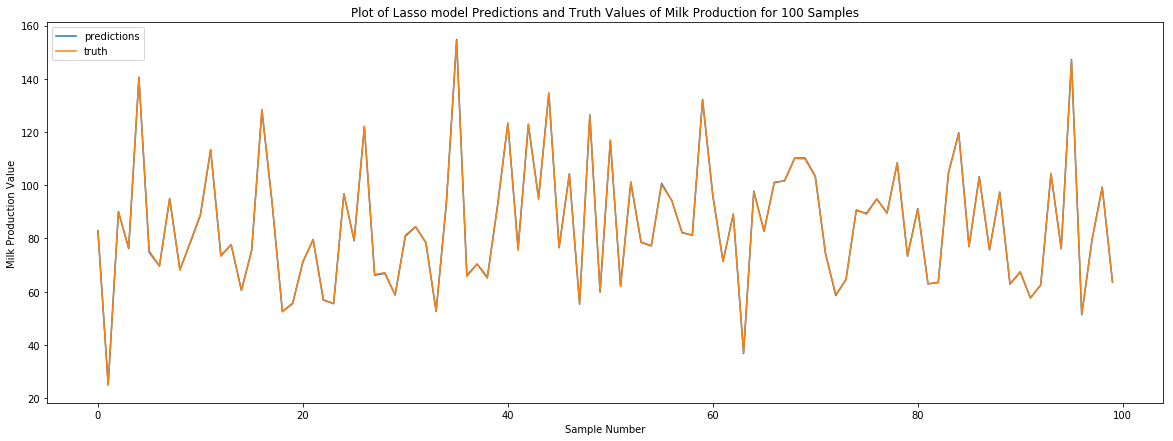

In [70]:
preds = lasso_preds["AvgMilk"]
_, _, _, actual = target_splits["AvgMilk"]

plt.figure(figsize=(20,7))
plt.plot(range(100), lasso_preds["AvgMilk"][:100])
plt.plot(range(100), actual[:100])
plt.legend(["predictions", "truth"])
plt.title("Plot of Lasso model Predictions and Truth Values of Milk Production for 100 Samples")
plt.xlabel("Sample Number")
plt.ylabel("Milk Production Value");

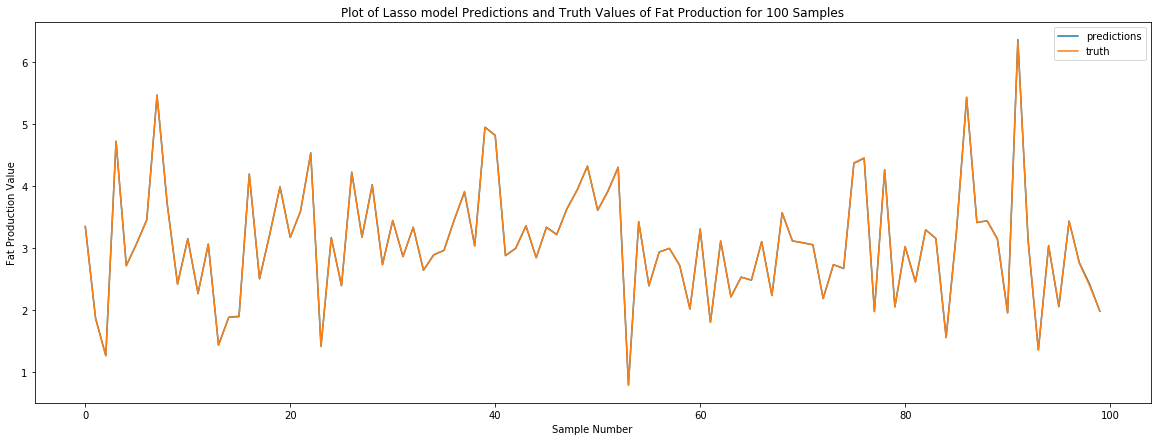

In [69]:
preds = lasso_preds["FatY"]
_, _, _, actual = target_splits["FatY"]

plt.figure(figsize=(20,7))
plt.plot(range(100), lasso_preds["FatY"][:100])
plt.plot(range(100), actual[:100])
plt.legend(["predictions", "truth"])
plt.title("Plot of Lasso model Predictions and Truth Values of Fat Production for 100 Samples")
plt.xlabel("Sample Number")
plt.ylabel("Fat Production Value");

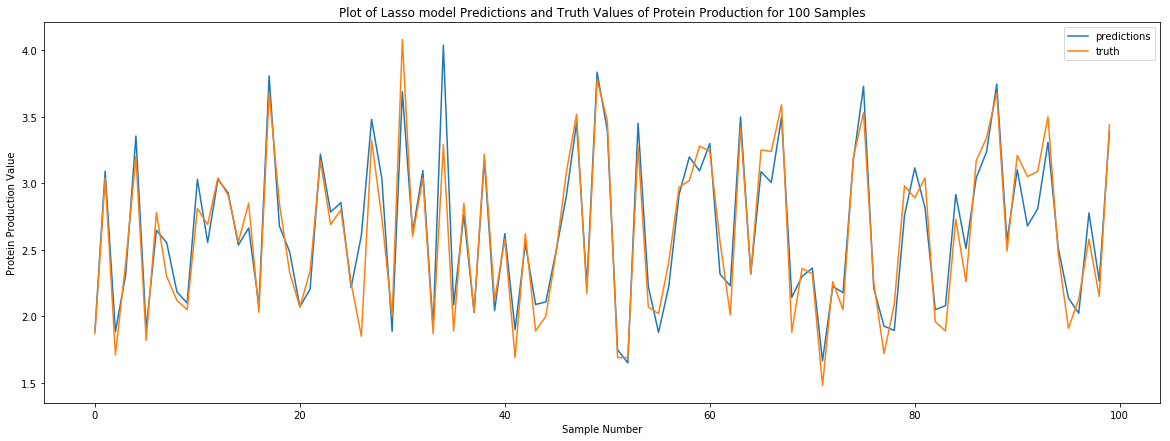

In [68]:
preds = lasso_preds["ProY"]
_, _, _, actual = target_splits["ProY"]

plt.figure(figsize=(20,7))
plt.plot(range(100), lasso_preds["ProY"][:100])
plt.plot(range(100), actual[:100])
plt.legend(["predictions", "truth"])
plt.title("Plot of Lasso model Predictions and Truth Values of Protein Production for 100 Samples")
plt.xlabel("Sample Number")
plt.ylabel("Protein Production Value");

### Heatmap of Feature Correlations with Targets

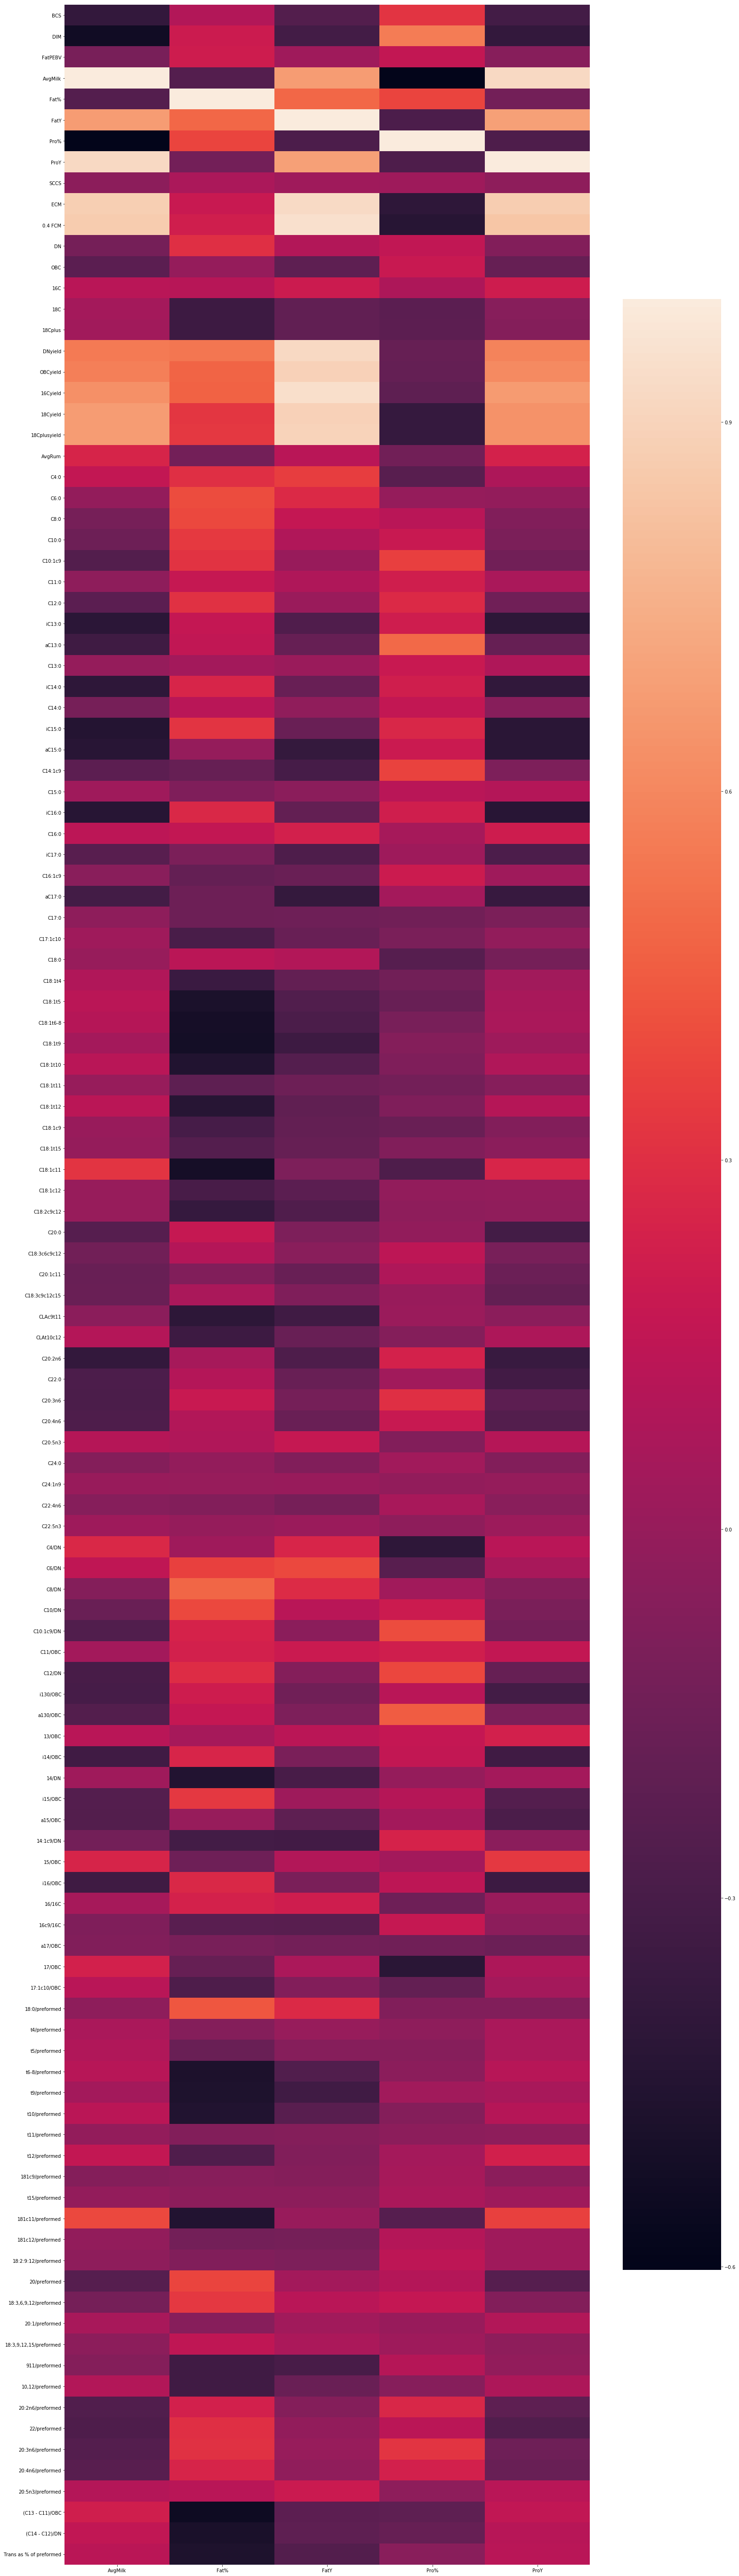

In [86]:
plt.figure(figsize = (25,100))
sns.heatmap(filtered_data.corr().loc[:,targets])

### Barplot of Null Values for Features

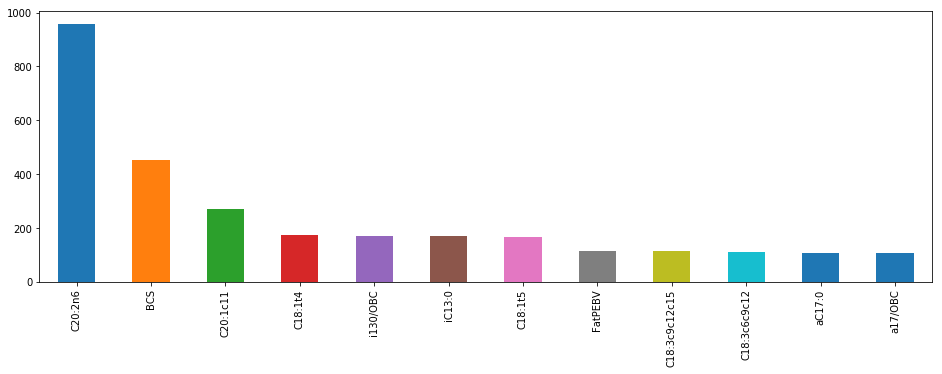

In [95]:
plt.figure(figsize=(16, 5))
null_summary.iloc[:12].plot.bar()